In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

<IPython.core.display.Javascript object>


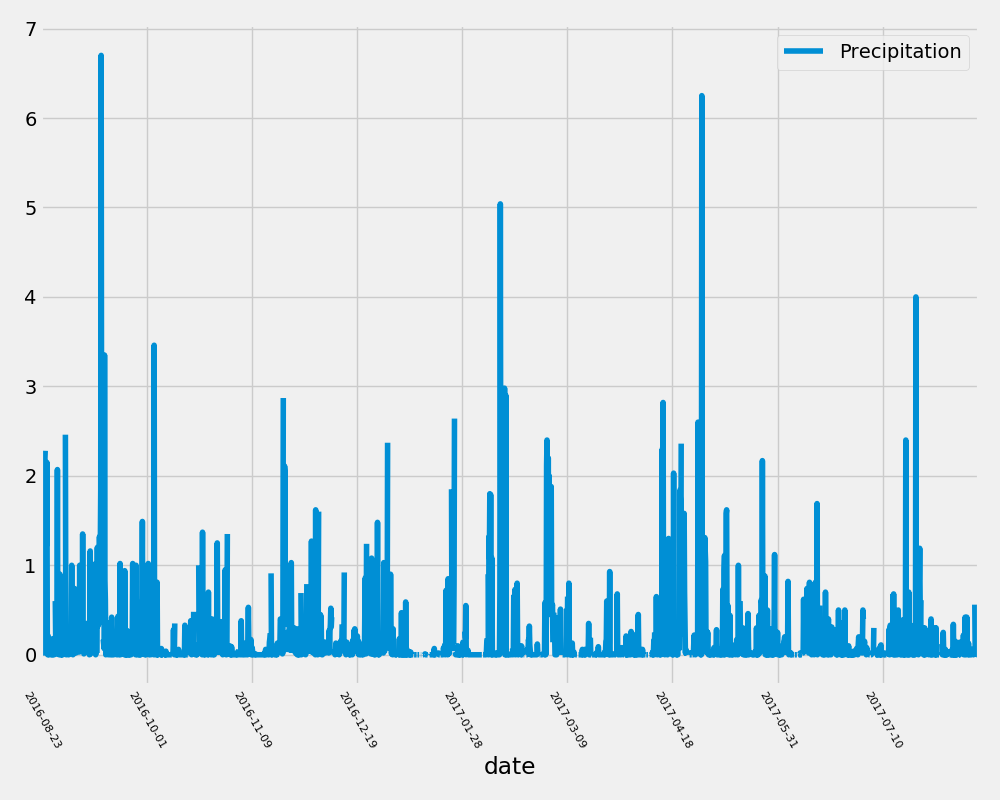

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
last_date_on_db = session.query(*[Measurement.date]).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date_on_db, '%Y-%m-%d') - dt.timedelta(365)
one_year_ago_str = dt.datetime.strftime(one_year_ago, '%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
query = session.query(*[Measurement.date, Measurement.prcp]).filter(func.strftime("%Y-%m-%d", Measurement.date)>= one_year_ago_str)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(query.statement, session.bind, index_col='date')

# Sort the dataframe by date
df_sorted_by_date = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates
fig, ax = plt.subplots(figsize=(10,8))
df_sorted_by_date.plot(ax=ax)
plt.xlabel('date')
plt.xticks(fontsize=8, rotation=-60)

ax.legend(['Precipitation'])
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sorted_by_date.describe()

,prcp
count,257.000000
mean,0.112451
std,0.328552
min,0.000000
25%,0.000000
50%,0.020000
75%,0.100000
max,4.000000


### Station Analysis

In [13]:
# How many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().all()
print(len(stations))

9


In [17]:
# What are the most active stations?

# Create a query to find the most active stations.
sel = [Measurement.station, func.count(Measurement.station)]
# List the stations and observation counts in descending order
stations_and_tobs = session.query(*sel).group_by(Measurement.station).order_by(-func.count(Measurement.station)).all()
stations_and_tobs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Which station has the highest number of observations?
station_with_highest_observations = stations_and_tobs[0][0]
station_with_highest_observations

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel_stats = [func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*sel_stats).filter(Measurement.station == station_with_highest_observations).all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


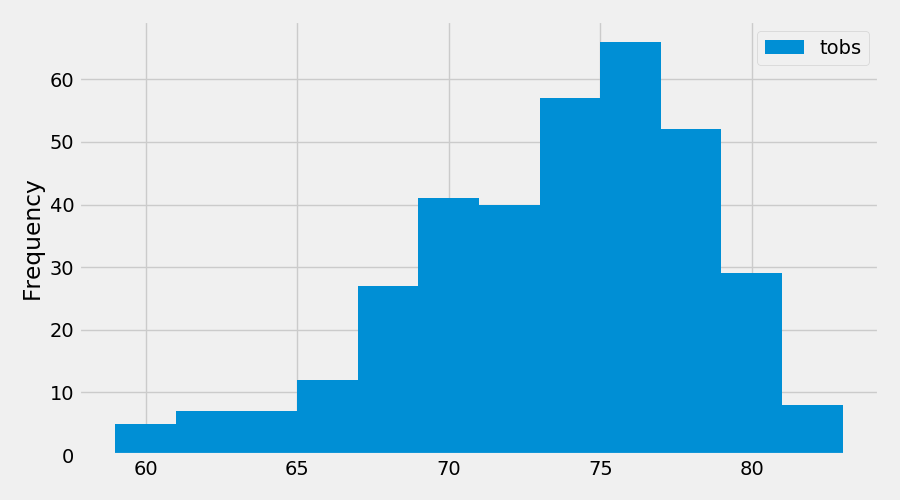

In [35]:
# Choose the station with the highest number of temperature observations.
last_date_on_db = session.query(*[Measurement.date]).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date_on_db, '%Y-%m-%d') - dt.timedelta(365)
one_year_ago_str = dt.datetime.strftime(one_year_ago, '%Y-%m-%d')
sel_tobs = [Measurement.tobs]

# Design a query to retrieve the last 12 months of temperature observation data (tobs).
query_last_12_mons = session.query(*sel_tobs).filter(func.strftime("%Y-%m-%d", Measurement.date)> one_year_ago_str).filter(Measurement.station == station_with_highest_observations)

# plot the results as a histogram with bins=12
df_tobs = pd.read_sql(query_last_12_mons.statement, session.bind, columns=['tobs'])
df_tobs.plot(kind='hist', bins=12, figsize=(9,5))
plt.tight_layout()


### Temperature Analysis

In [46]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start = '2017-07-01'
vacation_end = '2017-07-11'
tmin, tavg, tmax = calc_temps(vacation_start, vacation_end)[0]
print(*calc_temps(vacation_start, vacation_end)[0])

69.0 78.03030303030303 87.0


<IPython.core.display.Javascript object>


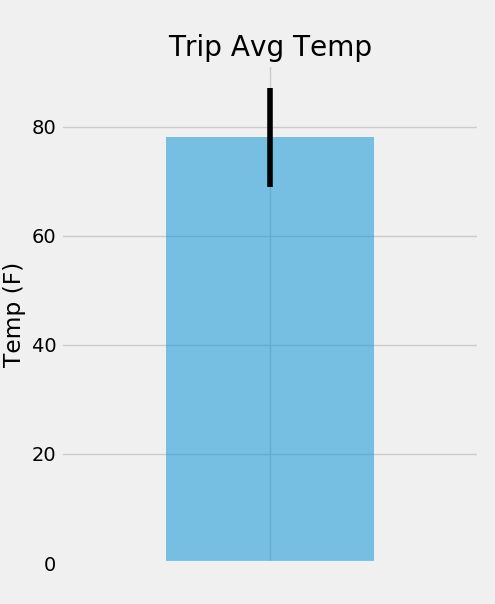

In [59]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = pd.Series([tavg])
errors = np.std([tmin, tmax])
fig, ax = plt.subplots()

avg_temp.plot(yerr=errors, ax=ax, kind='bar', alpha=0.5, ecolor='black')
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
plt.tight_layout()
plt.show()

In [63]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

records = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp)\
    .join(Measurement,Measurement.station==Station.station)\
    .filter(Measurement.date >= vacation_start)\
    .filter(Measurement.date <= vacation_end).order_by(Measurement.prcp.desc()).all()
records

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.5),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.4),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.3),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.18),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.15),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.15),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.11),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.1),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.09),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.08),
 ('USC00519281

## Optional Challenge Assignment

In [64]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [88]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
vacation_start_dt = dt.datetime.strptime(vacation_start, '%Y-%m-%d')
vacation_end_dt = dt.datetime.strptime(vacation_end, '%Y-%m-%d')
# Use the start and end date to create a range of dates
date_range = [vacation_start_dt + dt.timedelta(days=x) for x in range(0, (vacation_end_dt-vacation_start_dt).days+1)]
# Stip off the year and save a list of %m-%d strings
date_range_str = [dt.datetime.strftime(d,'%m-%d') for d in date_range]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(dstr)[0] for dstr in date_range_str]
normals

[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0)]

In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
trip_date_str = [dt.datetime.strftime(d,'%Y-%m-%d') for d in date_range]
temp_df['date'] = trip_date_str
temp_df.set_index('date', inplace=True)
temp_df

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


<IPython.core.display.Javascript object>


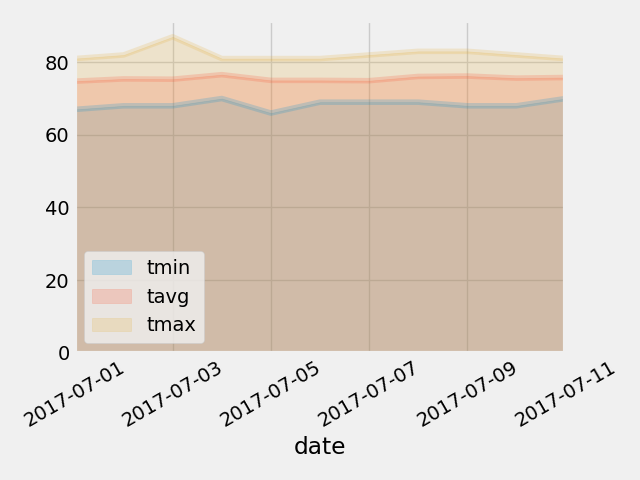

In [104]:
# Plot the daily normals as an area plot with `stacked=False`
ax=temp_df.plot.area(stacked=False, alpha=0.2)
ax.xaxis.set_tick_params(rotation=30)
plt.tight_layout()